In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid', {"axes.facecolor": ".96"})

import missingno as msno

In [2]:
df = pd.read_csv('fraud_df.csv')
print(df.shape)
print()
df.head()

(4156, 29)



dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  close_loans_cnt  federal_district_nm  \
0        1.0         0.0         0.0              0.0                    6   
1        NaN         NaN         NaN              2.0                    1   
2        NaN         NaN         NaN              1.0                    6   
3        NaN         NaN         NaN              0.0                    5   
4        NaN         NaN         NaN              2.0                    3   

   payment_type_0  payment_type_1  payment_type_2  payment_type_3  \
0               0               0               6               0   
1               0               0               0               5   
2               0               0               4               0   
3               0               3               0               0   
4               0               0               6               0   

   payment_type_4  ...  rep_loan_date_day  rep_loan_date_weekday  \
0               0  ...                 26                      2   
1               0  ...                 30                      3   
2               0  ...                 29                      6   
3               0  ...                  1                      5   
4               0  ...                  1                      2   

   first_loan_year  first_loan_month  first_loan_day  first_loan_weekday  \
0             2015                 9              28                   1   
1             2015                12              21                   1   
2             2015                 6              30                   5   
3             2015                 8               3                   1   
4             2015                 8              30                   3   

   first_overdue_date_year  first_overdue_date_month  first_overdue_date_day  \
0                   2016.0                       1.0                    30.0   
1                      NaN                       NaN                     NaN   
2                      NaN                       NaN                     NaN   
3                      NaN                       NaN                     NaN   
4                      NaN                       NaN                     NaN   

   first_overdue_date_weekday  
0                           2  
1                          -1  
2                          -1  
3                          -1  
4                          -1  

[5 rows x 29 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156 entries, 0 to 4155
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dpd_5_cnt                   675 non-null    float64
 1   dpd_15_cnt                  675 non-null    float64
 2   dpd_30_cnt                  675 non-null    float64
 3   close_loans_cnt             4141 non-null   float64
 4   federal_district_nm         4156 non-null   int64  
 5   payment_type_0              4156 non-null   int64  
 6   payment_type_1              4156 non-null   int64  
 7   payment_type_2              4156 non-null   int64  
 8   payment_type_3              4156 non-null   int64  
 9   payment_type_4              4156 non-null   int64  
 10  payment_type_5              4156 non-null   int64  
 11  past_billings_cnt           3908 non-null   float64
 12  score_1                     3507 non-null   float64
 13  score_2                     239 n

<Axes: >

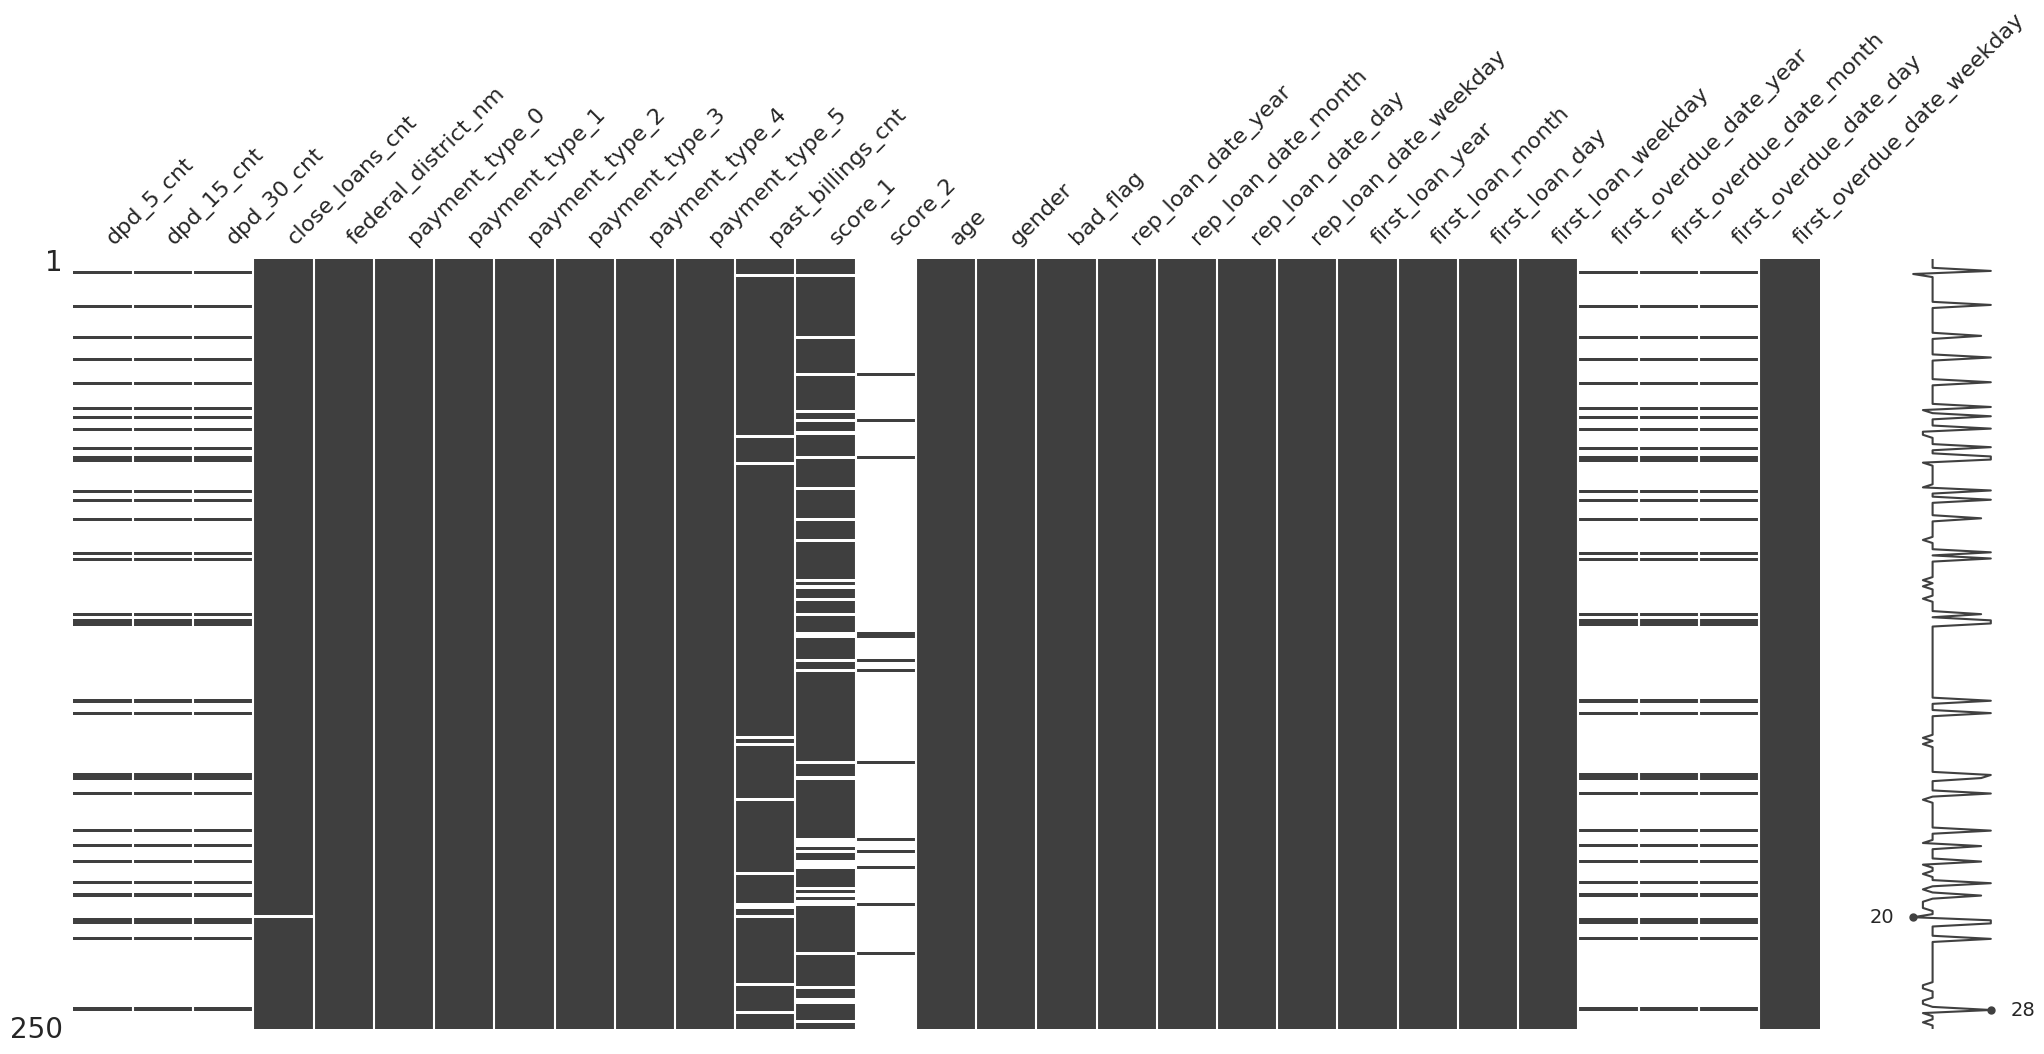

In [4]:
msno.matrix(df.sample(250))

Score_2 is the sparsest column. With only 239 non-null values it is a candidate to drop. However, the matrix indicates that those non-null 239 values are placed exactly where score_1 has a null value.

In [5]:
if df.loc[df['score_2'].notna(), 'score_1'].isna().all():
    print("Every non-null score_2 corresponds to null in score_1")

Every non-null score_2 corresponds to null in score_1


In [6]:
df[['score_1', 'score_2']].describe()

score_1     score_2
count  3507.000000  239.000000
mean    578.911345  552.546610
std      48.989869   21.492840
min     384.220628  485.874267
25%     547.429791  535.545724
50%     588.531315  556.757944
75%     612.323090  567.608057
max     691.528420  603.311653

The scores are in the roughly same scale, lets join them.

In [7]:
df['score_combined'] = df['score_1'].fillna(df['score_2'])
df = df.drop(columns=['score_1', 'score_2'])

In [8]:
sparse = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'first_overdue_date_year',
       'first_overdue_date_month', 'first_overdue_date_day']

for s in sparse:
      a = df.groupby(df[s].isna())["bad_flag"].mean()
      print(a)
      print()

dpd_5_cnt
False    0.195556
True     0.081873
Name: bad_flag, dtype: float64

dpd_15_cnt
False    0.195556
True     0.081873
Name: bad_flag, dtype: float64

dpd_30_cnt
False    0.195556
True     0.081873
Name: bad_flag, dtype: float64

first_overdue_date_year
False    0.195556
True     0.081873
Name: bad_flag, dtype: float64

first_overdue_date_month
False    0.195556
True     0.081873
Name: bad_flag, dtype: float64

first_overdue_date_day
False    0.195556
True     0.081873
Name: bad_flag, dtype: float64



Sparse columns hold information about customers with an overdue history. Rows where the value is not NaN are more than twice as likely to be bad flagged as those where the value is missing.
The mere presence or absence of a value (NaN vs. non-NaN) carries information about the risk of bad flagging. Dripping NaN rows or sparse columns aret thus a  bad strategy for this dataset.

In [9]:
df['has_overdue_info'] = df['first_overdue_date_year'].notna().astype(int)
df.drop(columns=[
    'first_overdue_date_year',
    'first_overdue_date_month',
    'first_overdue_date_day',
    'first_overdue_date_weekday'
], inplace=True)

The overdue date columns only add noise and complexity to the dataset, so I replaced them with a simple flag indicating whether any overdue information is present.

In [10]:
drop_cols = [
    # leakage
    'rep_loan_date_year',
    'rep_loan_date_month',
    'rep_loan_date_day',
    'rep_loan_date_weekday',

    # noise
    'first_loan_month',
    'first_loan_day',
    'first_loan_weekday',
]

df = df.drop(columns=drop_cols, errors='ignore')

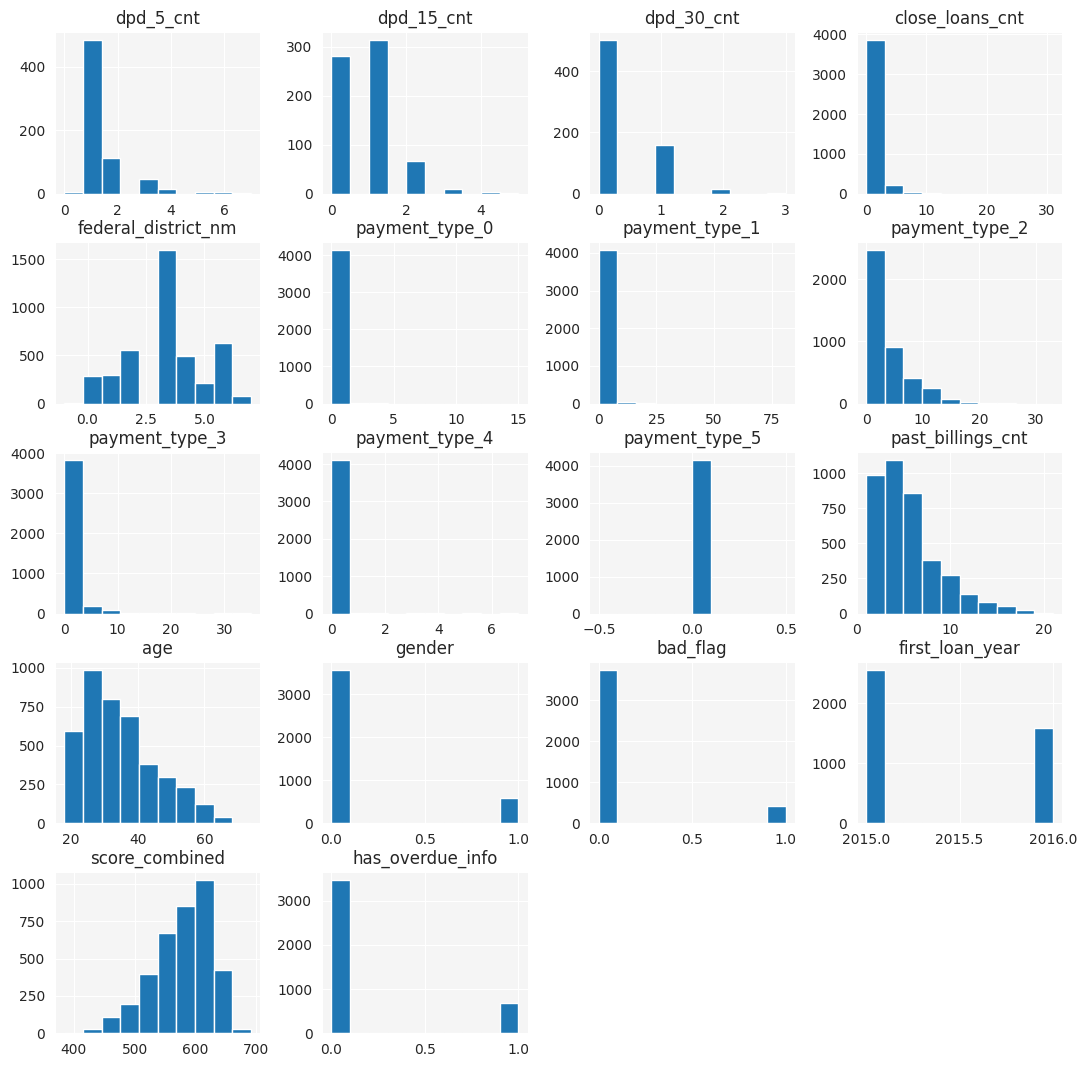

In [11]:
# check distributions across variables
df.hist(figsize=(13,13))
plt.show()

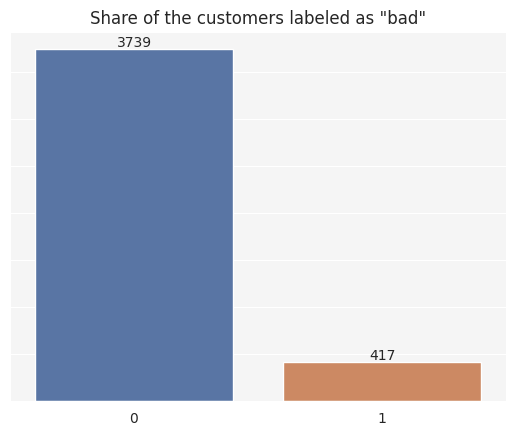

In [12]:
# display distribution of the target variable
ax = sns.countplot(data=df,
                   x='bad_flag', 
                   hue='bad_flag',
                   palette='deep',
                   legend=False)

plt.title('Share of the customers labeled as "bad"')
for container in ax.containers:
    ax.bar_label(container)
    
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
    
plt.show()

Histograms and and boxplots indicate several very imbalanced/sparse classes, including `payment_type_5` having just 1 unique value. 

In [13]:
# display the exact level of imbalance
sparse_info = pd.DataFrame({
    "dominant_share": df.apply(lambda x: x.value_counts(normalize=True, dropna=False).iloc[0]
                               if x.notna().sum() > 0 else np.nan)
}).sort_values(by="dominant_share", ascending=False)


print(sparse_info)

                     dominant_share
payment_type_5             1.000000
payment_type_0             0.993263
payment_type_4             0.990135
bad_flag                   0.899663
payment_type_1             0.874639
gender                     0.858758
dpd_15_cnt                 0.837584
dpd_5_cnt                  0.837584
has_overdue_info           0.837584
dpd_30_cnt                 0.837584
payment_type_3             0.806304
first_loan_year            0.616218
close_loans_cnt            0.402310
federal_district_nm        0.383782
payment_type_2             0.214389
past_billings_cnt          0.194177
score_combined             0.098653
age                        0.045717


In [14]:
# drop extremly sparse classes
df.drop(['payment_type_5','payment_type_4','payment_type_0'], axis=1, inplace=True)

The dataset is of unknown origin and lacks documentation. Therefore, the relationship between the credit score and `bad_flag` is unclear. If `bad_flag` is directly or indirectly derived from the score (or vice versa), it could cause data leakage.

Check the relationship:

In [15]:
df.groupby('bad_flag')['score_combined'].describe()

count        mean        std         min         25%         50%  \
bad_flag                                                                      
0         3414.0  581.431631  45.454059  385.181110  552.861759  588.420530   
1          332.0  534.015480  53.520111  384.220628  495.805064  533.910428   

                 75%         max  
bad_flag                          
0         612.364712  691.528420  
1         572.936126  682.760226

The test proves a clear relationship between `bad_flag` and `score_combined`. However, it is still unclear where this relationship comes from. Rather than dropping `score_combined` immediately, I decided to split the dataset and test the results both with and without the score variable.

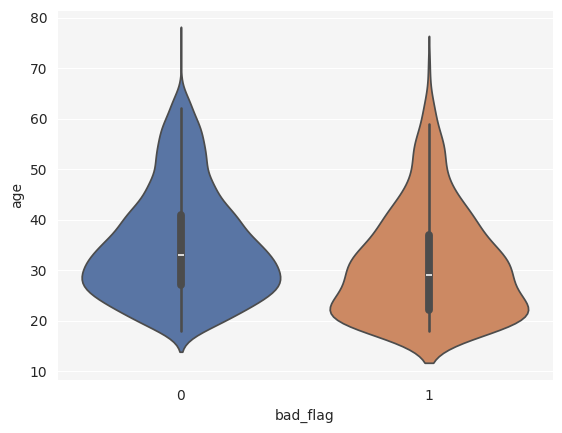

In [24]:
sns.violinplot(
    x='bad_flag',
    y='age',
    data=df,
    hue='bad_flag',
    palette='deep',
    legend=False
)

plt.show()

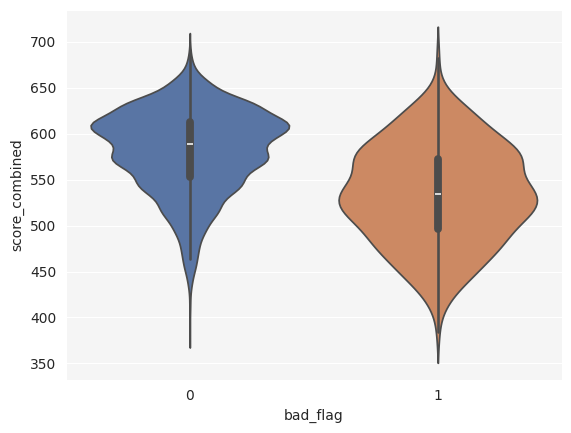

In [25]:
sns.violinplot(
    x='bad_flag',
    y='score_combined',
    data=df,
    hue='bad_flag',
    palette='deep',
    legend=False
)

plt.show()

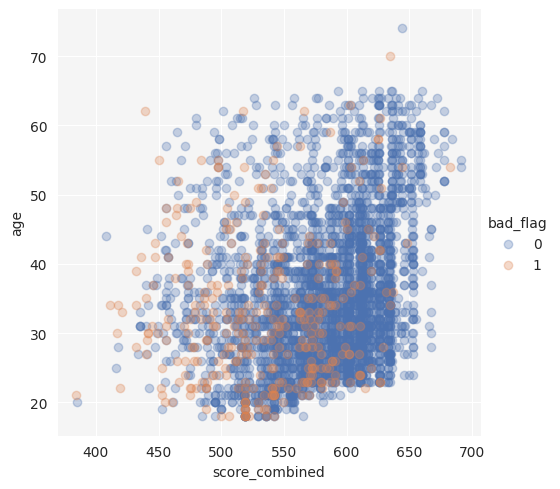

In [27]:
sns.lmplot(x='score_combined',
           y='age',
           hue='bad_flag',
           data=df,
           palette='deep',
           fit_reg=False,
           scatter_kws={'alpha':0.3})
plt.show()

While there is a relationship between the `bad_flag` and `score_combined`variables, the scatterplot shows that a low credit score does not necessarily lead to a bad flag

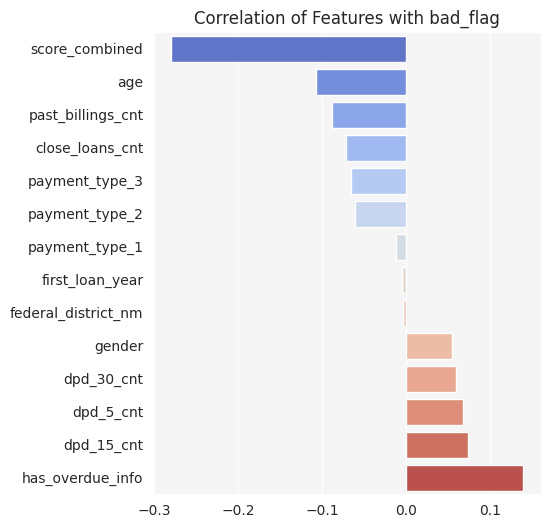

In [19]:
# check correlations with the target variable
fig, ax = plt.subplots(figsize=(5, 6))

target_corr = df.corr()['bad_flag'].drop('bad_flag')  
target_corr_sorted = target_corr.sort_values()

sns.barplot(
    x=target_corr_sorted.values,
    y=target_corr_sorted.index,
    palette=sns.color_palette("coolwarm", len(target_corr_sorted)),
    hue=target_corr_sorted.index                         
)

ax.set_title('Correlation of Features with bad_flag')
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()

`score_combined` is the only variable with a significant correlation to the target variable.

In [20]:
df.drop(['first_loan_year','federal_district_nm'], axis=1, inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156 entries, 0 to 4155
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dpd_5_cnt          675 non-null    float64
 1   dpd_15_cnt         675 non-null    float64
 2   dpd_30_cnt         675 non-null    float64
 3   close_loans_cnt    4141 non-null   float64
 4   payment_type_1     4156 non-null   int64  
 5   payment_type_2     4156 non-null   int64  
 6   payment_type_3     4156 non-null   int64  
 7   past_billings_cnt  3908 non-null   float64
 8   age                4156 non-null   int64  
 9   gender             4156 non-null   int64  
 10  bad_flag           4156 non-null   int64  
 11  score_combined     3746 non-null   float64
 12  has_overdue_info   4156 non-null   int64  
dtypes: float64(6), int64(7)
memory usage: 422.2 KB


### Handling Missing Values ‚Äì Strategy Comparison

| Strategy | Advantages | Disadvantages | Recommendation for This Case |
|-----------|-------------|----------------|-------------------------------|
| **Drop NaN rows** | Simple, results in a clean dataset | Lose ~80% of the data ‚Üí massive information loss; model would be biased (trained only on ‚Äúbad‚Äù cases) | ‚ùå Very unsuitable |
| **Impute (e.g., 0, median)** | Works for models that cannot handle NaNs | Here, 0 has no meaning (0 ‚â† date), adds noise ‚Üí ‚Äúartificial history‚Äù | üö´ Worse than flagging |
| **Flag NaN (add `has_overdue` feature)** | Keeps the information that ‚ÄúNaN exists‚Äù | For most clients (= 0) it may be almost constant, but combined with other features it can still be valuable | ‚úÖ Acceptable choice |
| **Keep NaN and use a model that supports it (CatBoost, XGBoost, LightGBM)** | No imputation needed; model internally splits on missingness | Requires compatible algorithms; interpretability of NaN handling can be tricky | ‚úÖ Strong choice for tree-based models |


In [22]:
# Saving cleaned and transformed dataset
df.to_csv('analytical_base_table.csv', index=None)